#Importing the Necessary Library Modules:

In [619]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


#Importing Lumle Data to forecast the Min/Max Temperature


In [620]:
data = pd.read_csv("/content/drive/MyDrive/CleanedFinalDateset/Lumlefinaldata.csv")
data.head()

,Date,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity
0,2010-01-01,0.0,12.5,3.0,82.15
1,2010-01-02,0.0,15.5,2.8,76.90
2,2010-01-03,0.0,15.5,4.8,86.65
3,2010-01-04,0.0,13.0,4.8,79.45
4,2010-01-05,0.0,13.8,4.2,75.70


In [621]:
data.isnull().sum()

Date                 0
Precipitation(mm)    0
Max Temperature      0
Min Temperature      0
Relative Humidity    0
dtype: int64

In [622]:
data.describe()

,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity
count,4852.000000,4852.000000,4852.000000,4852.000000
mean,13.836523,20.671094,11.954885,82.122079
std,26.989407,4.098879,4.925632,14.004509
min,0.000000,6.500000,-1.200000,30.000000
25%,0.000000,17.500000,7.600000,74.400000
50%,0.000000,21.500000,12.500000,85.725000
75%,14.500000,24.000000,16.800000,93.250000
max,130.000000,30.100000,20.000000,100.000000


In [623]:
train_dates=pd.to_datetime(data['Date'])

# Creating the lag features, so that model will capture the periodicity

In [624]:
#mentioned 2 lags for the precipitation
for i in [1]:
    data["lag_f{}".format(i)] = data['Max Temperature'].shift(periods=i)

data['lag_f1']=data['lag_f1'].fillna(0)
# data['lag_f2']=data['lag_f2'].fillna(0)
# data['lag_f3']=data['lag_f3'].fillna(0)

# data[['Precipitation(mm)', 'lag_f1', 'lag_f2', 'lag_f3' ]]

In [625]:
data[:10]

,Date,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity,lag_f1
0,2010-01-01,0.0,12.5,3.0,82.15,0.0
1,2010-01-02,0.0,15.5,2.8,76.90,12.5
2,2010-01-03,0.0,15.5,4.8,86.65,15.5
3,2010-01-04,0.0,13.0,4.8,79.45,15.5
4,2010-01-05,0.0,13.8,4.2,75.70,13.0
5,2010-01-06,0.0,16.0,4.5,81.60,13.8
6,2010-01-07,0.0,16.5,5.0,82.60,16.0
7,2010-01-08,0.0,17.5,6.3,85.25,16.5
8,2010-01-09,0.0,17.5,5.3,85.25,17.5
9,2010-01-10,0.0,17.0,4.8,79.65,17.5


In [626]:
# # Convert date column to datetime format
# data['Date'] = pd.to_datetime(data['Date'])

# # Create new features for day of week and month of year
# data['day_of_week'] = data['Date'].dt.dayofweek
# data['month'] = data['Date'].dt.month

# # Create sine and cosine features for day of week
# data['day_of_week_sin'] = np.sin(2*np.pi*data['day_of_week']/7)
# data['day_of_week_cos'] = np.cos(2*np.pi*data['day_of_week']/7)

# # Create sine and cosine features for month of year
# data['month_sin'] = np.sin(2*np.pi*data['month']/12)
# data['month_cos'] = np.cos(2*np.pi*data['month']/12)

In [627]:
data[30:39]

,Date,Precipitation(mm),Max Temperature,Min Temperature,Relative Humidity,lag_f1
30,2010-01-31,0.0,17.0,6.3,71.70,16.5
31,2010-02-01,0.0,14.0,6.0,84.45,17.0
32,2010-02-02,0.0,15.0,5.5,62.60,14.0
33,2010-02-03,0.0,14.8,5.0,48.95,15.0
34,2010-02-04,0.0,15.2,5.0,47.15,14.8
35,2010-02-05,0.0,15.0,4.5,51.15,15.2
36,2010-02-06,0.0,15.0,6.0,87.35,15.0
37,2010-02-07,0.0,16.2,6.2,75.05,15.0
38,2010-02-08,0.0,16.0,6.0,82.25,16.2


In [628]:
#drop the day of week and month column
# new_df = data.drop(['Date','day_of_week', 'month'], axis=1)
new_df = data.drop(['Date'], axis=1)


In [629]:
new_df.isnull().sum()

Precipitation(mm)    0
Max Temperature      0
Min Temperature      0
Relative Humidity    0
lag_f1               0
dtype: int64

In [630]:
#splitting training testing dataset
X_train, X_test, y_train, y_test = train_test_split(new_df, new_df['Max Temperature'], test_size = 0.2, shuffle = False)
     

In [631]:
y_train[:5]

0    12.5
1    15.5
2    15.5
3    13.0
4    13.8
Name: Max Temperature, dtype: float64

#To normalize the data into the same differences

In [632]:
#Normalize the data and  change into array and reshape to fit the LSTM model
scaler = MinMaxScaler()

#normalize the train and test dataset
X_train_arr=scaler.fit_transform(X_train)
X_test_arr=scaler.transform(X_test)

#reshaping it into the single column data 
y_train_arr=scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_arr=scaler.transform(np.array(y_test).reshape(-1,1))

trainX = X_train_arr.reshape((X_train_arr.shape[0], 1 ,X_train_arr.shape[1]))
trainY = y_train_arr.reshape((y_train_arr.shape[0], 1, y_train_arr.shape[1]))

testX= X_test_arr.reshape((X_test_arr.shape[0], 1 ,X_test_arr.shape[1]))
testY = y_test_arr.reshape((y_test_arr.shape[0], 1, y_test_arr.shape[1]))

# Building Model

In [ ]:
#Building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=((1,5)), activation='tanh', return_sequences=True),
  tf.keras.layers.LSTM(32, activation='tanh'),
  tf.keras.layers.Dense(1)
  ])




In [ ]:
  # Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)


  # Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
model.summary()


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 1, 512)            1060864   
                                                                 
 lstm_97 (LSTM)              (None, 32)                69760     
                                                                 
 dense_40 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,130,657
Trainable params: 1,130,657
Non-trainable params: 0
_________________________________________________________________


In [613]:
model_history = model.fit(trainX, trainY, batch_size=5, validation_data=(testX,testY), epochs=10)

Epoch 1/10
777/777 [==============================] - 21s 16ms/step - loss: 0.0154 - val_loss: 0.0105
Epoch 2/10
777/777 [==============================] - 10s 13ms/step - loss: 0.0081 - val_loss: 0.0053
Epoch 3/10
777/777 [==============================] - 12s 16ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 4/10
777/777 [==============================] - 12s 16ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/10
777/777 [==============================] - 14s 18ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/10
777/777 [==============================] - 12s 16ms/step - loss: 9.1953e-04 - val_loss: 9.3912e-04
Epoch 7/10
777/777 [==============================] - 11s 15ms/step - loss: 7.8378e-04 - val_loss: 7.9550e-04
Epoch 8/10
777/777 [==============================] - 13s 17ms/step - loss: 6.9079e-04 - val_loss: 6.9914e-04
Epoch 9/10
777/777 [==============================] - 12s 15ms/step - loss: 6.2763e-04 - val_loss: 6.2495e-04
Epoch 10/10
777/777 [=============================

# Loss in Training and Validation over the different epoches


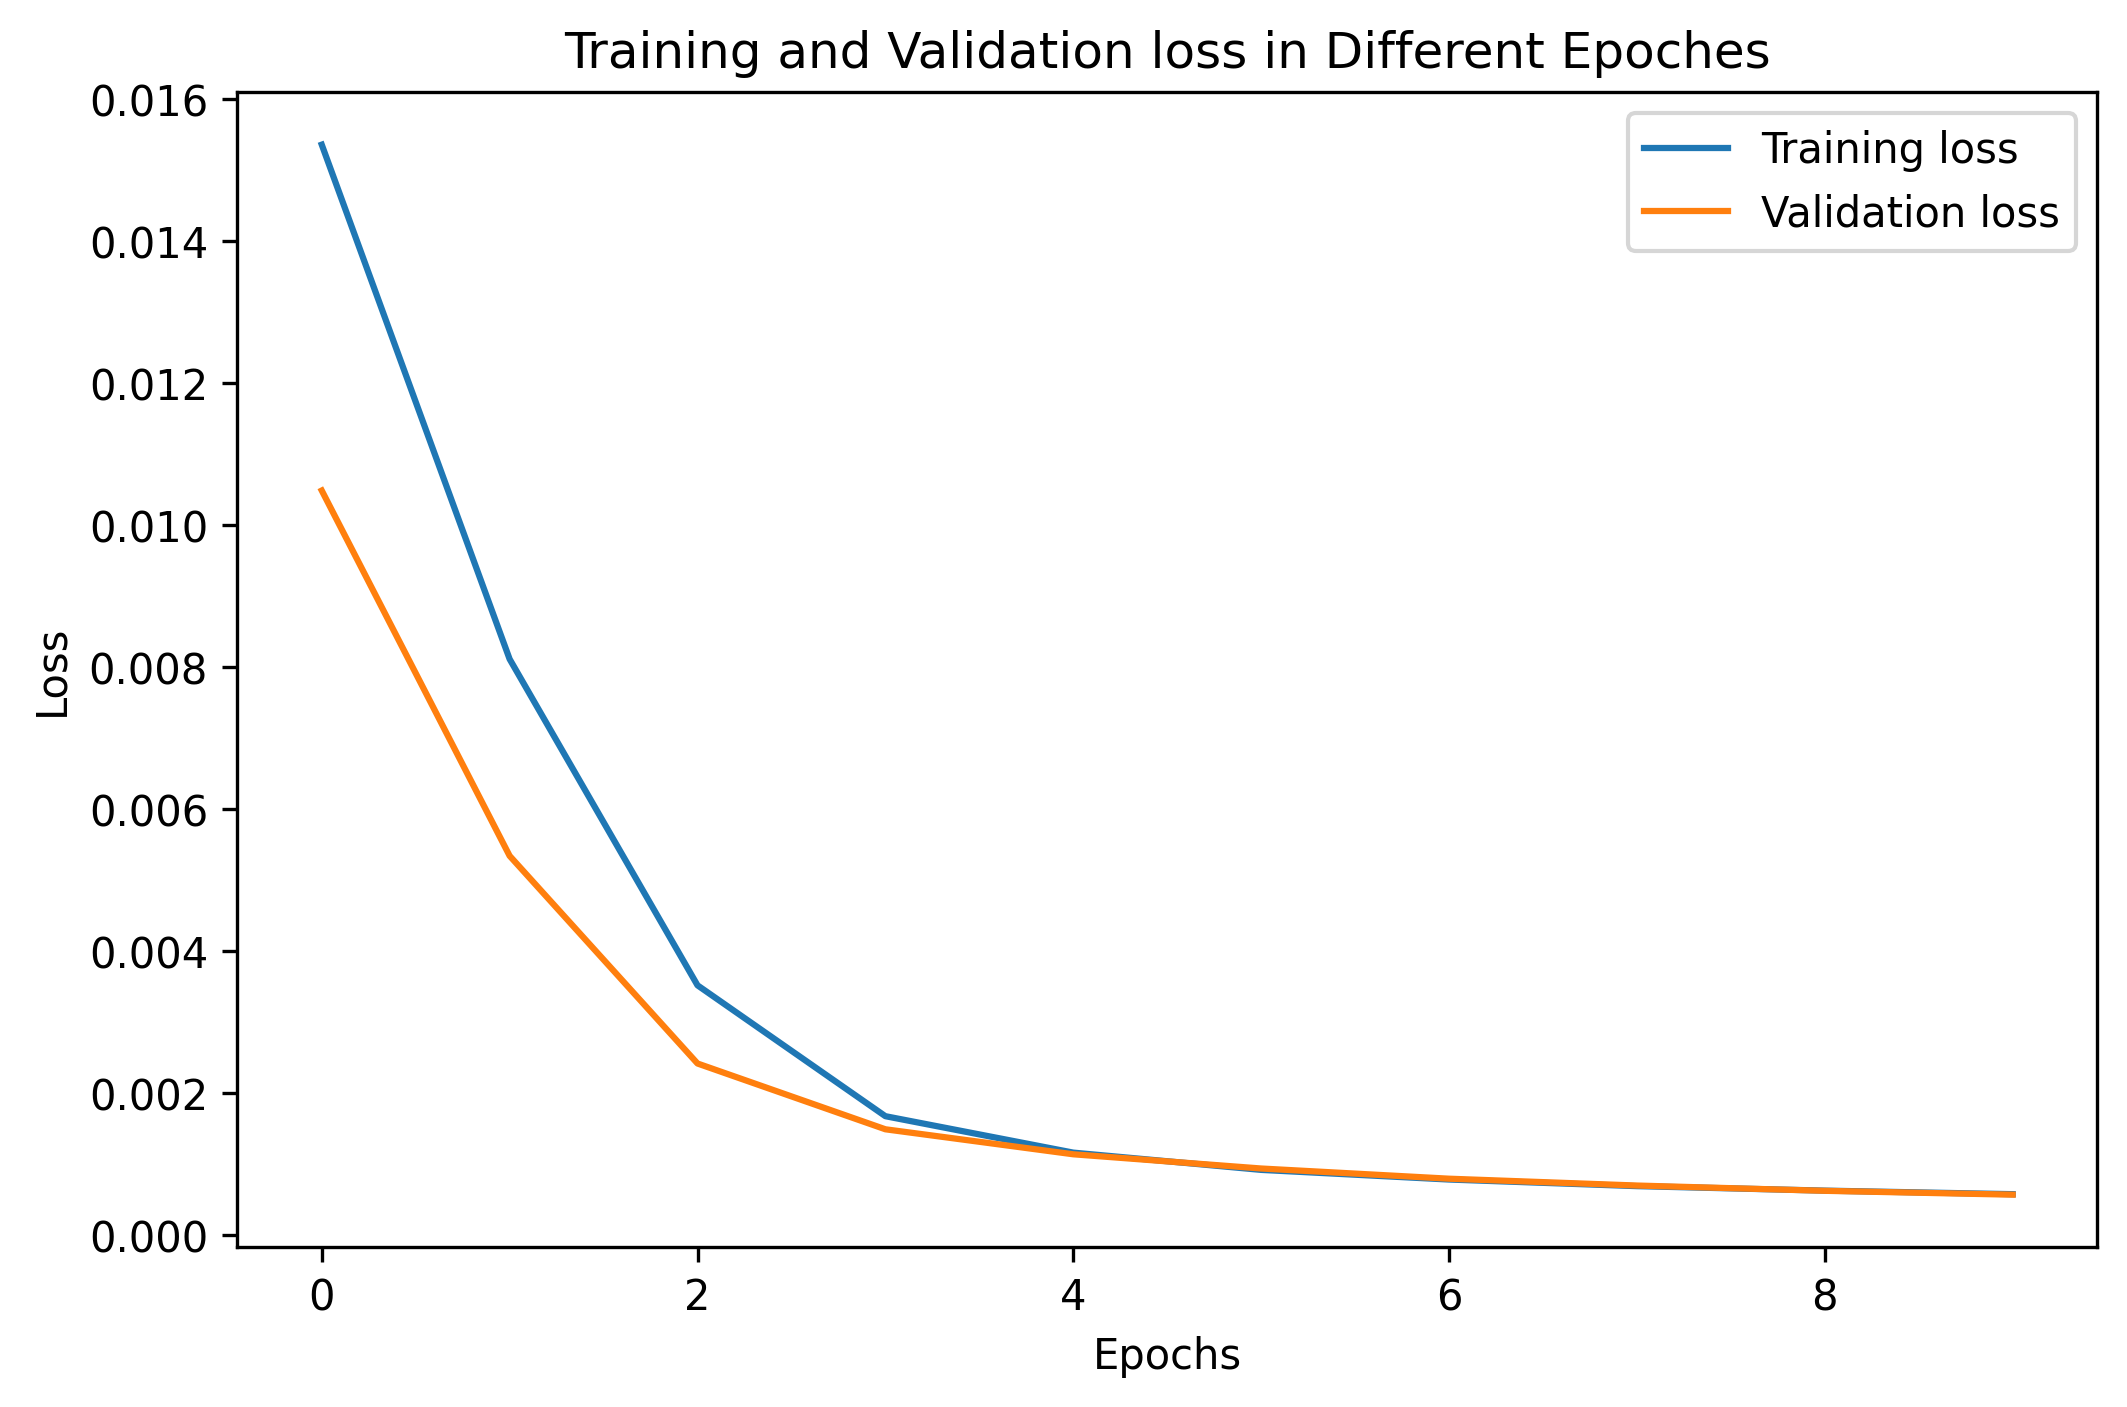

In [614]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(model_history.history)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss in Different Epoches')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# Plotting the Predicted and Actual Graphs and Evaluations

Text(0.5, 1.0, 'Lumle Max Temperature Actual Data Vs Predicted Data')

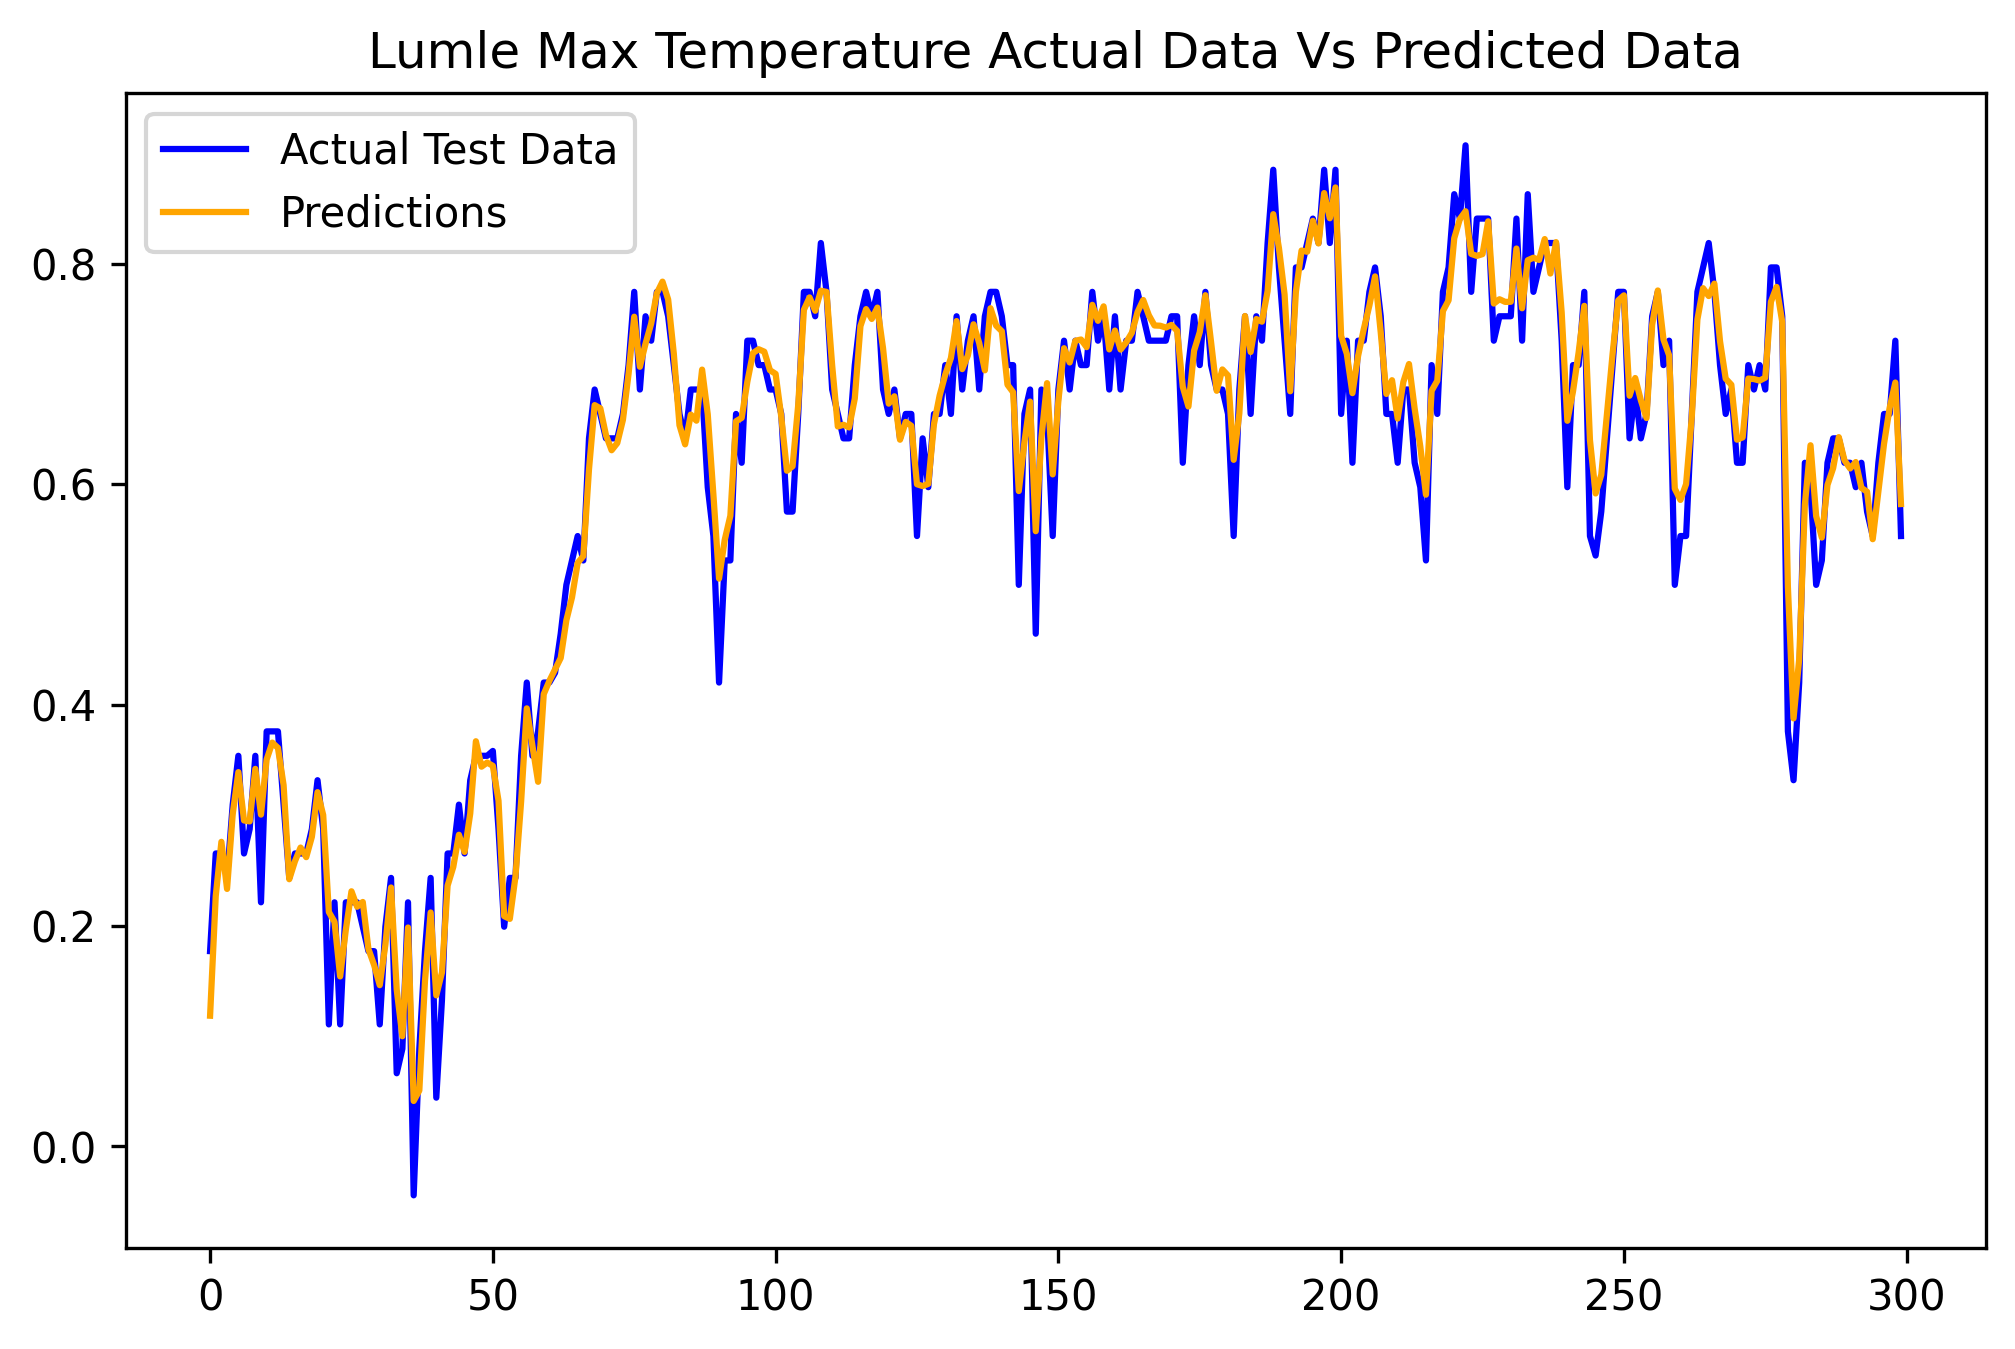

In [615]:
#Plotting the Predicted vs Testing accuracy aspect
yPredict_train =model.predict(testX, verbose=0)


import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,5), dpi=300)

ax.plot(y_test_arr[500:800], color='blue', linewidth=1.5, label = "Actual Test Data")
ax.plot(yPredict_train[500:800], color='orange',linewidth=1.5,label = "Predictions")

ax.legend()
ax.set_title('Lumle Max Temperature Actual Data Vs Predicted Data')

#Calculating RMSE and Accuracy of Model

In [616]:
def Evaluation(train, train_pred, test, test_pred):
  # calculate root mean squared error
  train_rmse = np.sqrt(mean_squared_error(train, train_pred))
  print('Train RMSE: %.2f' % (train_rmse))
  test_rmse = np.sqrt(mean_squared_error(test, test_pred))
  print('Test RMSE: %.2f' % (test_rmse))

  # calculate root mean absolute error
  train_mae = mean_absolute_error(train, train_pred)
  print('Train MAE: %.2f' % (train_mae))
  test_mae = mean_absolute_error(test, test_pred)
  print('Test MAE: %.2f' % (test_mae))

  # Calculate r2_score
  train_r2 = r2_score(train, train_pred)
  print('Train r2 score: %.2f' % (train_r2))
  test_r2 = r2_score(test, test_pred)
  print('Test r2 score: %.2f' % (test_r2))

In [636]:
yPredict_train = model.predict(trainX, verbose=0)
yPredict_test = model.predict(testX, verbose=0)

Denormalize_yPredict_train = scaler.inverse_transform(yPredict_train)
Denormalize_trainY = scaler.inverse_transform(y_train_arr)
Denormalize_yPredict_test = scaler.inverse_transform(yPredict_test)
Denormalize_testY = scaler.inverse_transform(y_test_arr)

In [639]:
Evaluation(Denormalize_trainY, Denormalize_yPredict_train, Denormalize_testY, Denormalize_yPredict_test)

Train RMSE: 0.74
Test RMSE: 0.76
Train MAE: 0.57
Test MAE: 0.58
Train r2 score: 0.97
Test r2 score: 0.96


In [642]:
Denormalize_testY.shape

(971, 1)

In [648]:
#make it into one column data so that concat will be easy
Predicted=Denormalize_yPredict_test.reshape(-1)
Actual=Denormalize_testY.reshape(-1)

In [650]:
#Concatination the result 
test_results=pd.DataFrame(data={'Max Temp Predictions':Predicted, 'Actuals': Actual})
test_results

,Max Temp Predictions,Actuals
0,25.388557,25.5
1,23.771002,22.0
2,23.249773,23.0
3,24.850935,25.0
4,24.405893,24.5
...,...,...
966,23.156742,23.0
967,23.753801,24.0
968,24.003311,24.5
969,25.237806,25.5


 # Tomorrow Prediction

In [659]:
next_day_predict=model.predict(testX[-1:])
next_day=scaler.inverse_transform(next_day_predict)
next_day

1/1 [==============================] - 0s 31ms/step


array([[25.702366]], dtype=float32)